In [785]:
import typing as T  # pylint: disable=unused-import

import numpy as np
import numpy.typing as npt

from pydrake.geometry.optimization import (  # pylint: disable=import-error, no-name-in-module
    HPolyhedron,
    Point,
    ConvexSet,
    Hyperrectangle,
    VPolytope,
    Hyperellipsoid,
    LoadIrisRegionsYamlFile,
)



from pydrake.symbolic import ( # pylint: disable=import-error, no-name-in-module, unused-import
    Polynomial,
    Variable,
    Variables,
    Expression,
)  

from pydrake.solvers import (  # pylint: disable=import-error, no-name-in-module, unused-import
    MathematicalProgram,
    MathematicalProgramResult,
    Solve,
    MosekSolver,
    MosekSolverDetails,
    SolverOptions,
    CommonSolverOption,
    IpoptSolver,
    SnoptSolver,
    GurobiSolver,
    OsqpSolver,
    ClarabelSolver,
)


from shortest_walk_through_gcs.util import (
    timeit,
    diditwork,
    INFO,
    YAY,
    WARN,
    ERROR,
    concatenate_polyhedra,
)  # pylint: disable=import-error, no-name-in-module, unused-import

import plotly.graph_objects as go  # pylint: disable=import-error
from plotly.express.colors import sample_colorscale  # pylint: disable=import-error
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from shortest_walk_through_gcs.gcs_dual import DualEdge, DualVertex, PolynomialDualGCS
from shortest_walk_through_gcs.program_options import FREE_POLY, PSD_POLY, CONVEX_POLY, ProgramOptions

import plotly
import plotly.graph_objs as go
from IPython.display import display, HTML

plotly.offline.init_notebook_mode()
display(HTML(
    '<script type="text/javascript" async src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/MathJax.js?config=TeX-MML-AM_SVG"></script>'
))

from shortest_walk_through_gcs.incremental_search import obtain_rollout, RestrictionSolution, precompute_k_step_feasible_paths_from_every_vertex

from dataclasses import dataclass

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

from testing_zmp_helpers import animate_footstep_plan, check_that_foot_forces_exist

# setting things up

In [786]:
options = ProgramOptions()
options.potential_polynomial_degree = 2
options.potential_type = PSD_POLY

options.solve_shortest_walk_not_path = True
options.s_procedure_multiplier_degree_for_linear_inequalities = 0 # TODO change me
options.s_procedure_take_product_of_linear_constraints = True # TODO change me

options.cost_to_go_synthesis_use_robust_mosek_parameters = True
options.cost_to_go_synthesis_MSK_DPAR_INTPNT_CO_TOL_REL_GAP = 1e-9
options.cost_to_go_synthesis_MSK_DPAR_INTPNT_CO_TOL_PFEAS = 1e-9
options.cost_to_go_synthesis_MSK_DPAR_INTPNT_CO_TOL_DFEAS = 1e-9

options.right_edge_point_must_be_inside_intersection_of_left_and_right_sets = False

options.potentials_are_not_a_function_of_target_state = True
options.relax_target_condition_during_rollout = False

In [787]:
# system parameters

# foot size
w = 0.14/2 # m
h = 0.26/2 # m


# body properties
g = 9.81 # m/s^2
m = 80 # kg
z = 0.8 # m
mu = 0.5 # coef of friction

# time discretization
# dt = 0.25 # s
dt = 0.5 # s

# environment  dimensions

v_max = 2.5 # m/s

In [788]:
@dataclass
class FootDisplacementParams:
    """
    A dataclass that contains all the robotic arm system components.
    """
    x1: float
    x2: float
    y3: float
    x4: float

In [789]:
fdp = FootDisplacementParams(1.9*w*2, 4*w*2, 2.75*h*2, 1.9*w*2)

# fdp = FootDisplacementParams(2*w*2, 6*w*2, 4.75*h*2, 1.9*w*2)

In [808]:
dy1 = 0.2
dy2 = 0.5
sq = 0.4
dx1 = 0.1
dy3 = 0.4

# dy1 = 0.1
# dy2 = 0.2
# sq = 0.4
# dx1 = 0.1
# dy3 = 0.1

stone_definitions = {
          "s": ([-0.6, -0.6], [0.6,0.6]),
          "m": ([-0.6, 0.6+dy1], [-0.6+sq, 0.6+dy2+sq+dy2-dy1]),
        #   "r": ([0.6-sq,0.6+dy2],[0.6, 0.6+dy2+sq]),
          "l": ([-0.6-dx1-sq, dy3],[-0.6-dx1, 0.6+dy2+sq+dy2+0.6-dy3]),
          "t": ([-0.6, 0.6+dy2+sq+dy2], [0.6, 0.6+dy2+sq+dy2+1.2])
}

# stone_definitions = {
#           "t": ([-2, -2], [2,2]),
# }

# stone_definitions = {
#           "s": ([-0.6, -0.6], [0.6,0.6]),
#           "t": ([-0.6, 0.7],  [0.6, 1.3])
# }


stone_polys = dict()
for name, stone_def in stone_definitions.items():
    lb,rb = stone_def
    delta = np.array([w,h])
    stone_polys[name] = HPolyhedron.MakeBox( delta+lb, -delta + rb )

art_pos_delta = 1.0
art_set = HPolyhedron.MakeBox([-3,-3],[3,3])


target_pos = np.sum(stone_definitions["t"], axis=0)/2
target_point = np.array([target_pos[0],target_pos[1],
                         0,0, 
                         target_pos[0]-w*2, target_pos[1], target_pos[0]+2*w, target_pos[1]])
INFO("target:", target_point)

target_bounds = np.array([0.02,0.02, 0.0075,0.0075, 0.001,0.001,0.001,0.001])
# target_bounds = np.array([0.5,0.5, 0.5,0.5, 0.5,0.5, 0.5,0.5])

target: [0.000 2.600 0.000 0.000 -0.140 2.600 0.140 2.600]


# cost function

In [809]:
# state:
# px py vx vy ll rr
# control:
# ax ay
control_cost = 0.1
time_cost = 1
foot_movement_cost = 0.1
foot_movement_cost_surrogate = 0.1

terminal_cost = np.diag([0.1,0.1, 0.01,0.01, 0.1,0.1,0.1,0.1])
terminal_cost_surrogate = np.diag([0.1,0.1, 0.01,0.01, 0.1,0.1,0.1,0.1])

terminal_cost_foot_in_air = np.diag([0.1,0.1, 0.01,0.01, 0,0,0,0])
terminal_cost_surrogate_foot_in_air = np.diag([0.1,0.1, 0.01,0.01, 0.0,0.0,0.0,0.0])
foot_down_cost = 0

def cost_function(xl,u,xr,xt,dt=dt):
    cost_expr = control_cost * u.dot(u) # control cost
    cost_expr += time_cost # time cost
    cost_expr += foot_movement_cost * (xr[4:6]-xl[4:6]).dot(xr[4:6]-xl[4:6]) # left  foot movement cost
    cost_expr += foot_movement_cost * (xr[6:8]-xl[6:8]).dot(xr[6:8]-xl[6:8]) # right foot movement cost
    cost_expr += (xl-target_point).dot(terminal_cost).dot(xl-target_point) # terminal cost
    return cost_expr * dt

def cost_function_surrogate(xl,u,xr,xt,dt=dt):
    cost_expr = control_cost * u.dot(u) # control cost
    cost_expr += time_cost # time cost
    cost_expr += foot_movement_cost_surrogate * (xr[4:6]-xl[4:6]).dot(xr[4:6]-xl[4:6]) # left foot movement cost
    cost_expr += foot_movement_cost_surrogate * (xr[6:8]-xl[6:8]).dot(xr[6:8]-xl[6:8]) # right foot movement cost
    cost_expr += (xl-target_point).dot(terminal_cost_surrogate).dot(xl-target_point) # terminal cost
    return cost_expr * dt


def cost_function_foot_in_air(xl,u,xr,xt,dt=dt):
    cost_expr = control_cost * u.dot(u) # control cost
    cost_expr += time_cost # time cost
    cost_expr += foot_movement_cost * (xr[4:6]-xl[4:6]).dot(xr[4:6]-xl[4:6]) # left  foot movement cost
    cost_expr += foot_movement_cost * (xr[6:8]-xl[6:8]).dot(xr[6:8]-xl[6:8]) # right foot movement cost
    cost_expr += (xl-target_point).dot(terminal_cost_foot_in_air).dot(xl-target_point) # terminal cost
    return cost_expr * dt

def cost_function_surrogate_foot_in_air(xl,u,xr,xt,dt=dt):
    cost_expr = control_cost * u.dot(u) # control cost
    cost_expr += time_cost # time cost
    cost_expr += foot_movement_cost_surrogate * (xr[4:6]-xl[4:6]).dot(xr[4:6]-xl[4:6]) # left foot movement cost
    cost_expr += foot_movement_cost_surrogate * (xr[6:8]-xl[6:8]).dot(xr[6:8]-xl[6:8]) # right foot movement cost
    cost_expr += (xl-target_point).dot(terminal_cost_surrogate_foot_in_air).dot(xl-target_point) # terminal cost
    return cost_expr * dt



# graph def

In [810]:
target_set = Hyperrectangle(target_point - target_bounds, target_point + target_bounds)
graph = PolynomialDualGCS(options, target_set)

In [811]:
velocity_polyhedron = Hyperrectangle([-v_max, -v_max], [v_max, v_max])

In [812]:
# slope = (fdp.y3/(fdp.x4-fdp.x1))

# right_foot_in_front_polyhedron    = HPolyhedron([[0,-1,0,1], # top hyperplane
#                                                  [-1,0,1,0], # right hyperplane
#                                                  [0,1,0,-1], # bottom hyperplane
#                                                  [-slope, 1, slope, -1]], # diagonal
#                                                  [fdp.y3, fdp.x2, 0, -fdp.y3 + fdp.x4*slope])

right_foot_in_front_polyhedron    = HPolyhedron([[0,-1,0,1], # top hyperplane
                                                 [-1,0,1,0], # right hyperplane
                                                 [0,1,0,-1], # bottom hyperplane
                                                 [1,0,-1,0]], # left hyperplane
                                                 [fdp.y3, fdp.x2, 0, -fdp.x4])

assert not right_foot_in_front_polyhedron.PointInSet([0,0,0,0])
assert right_foot_in_front_polyhedron.PointInSet([0,0,fdp.x1,0])
assert right_foot_in_front_polyhedron.PointInSet([0,0,fdp.x2,0])
assert right_foot_in_front_polyhedron.PointInSet([0,0,fdp.x2,fdp.y3])
assert right_foot_in_front_polyhedron.PointInSet([0,0,fdp.x4,fdp.y3])

# right_front_behind_polyhedron     = HPolyhedron([[0,-1,0,1], # top hyperplane
#                                                  [-1,0,1,0], # right hyperplane
#                                                  [0,1,0,-1], # bottom hyperplane
#                                                  [-slope, -1, slope, 1]], # diagonal
#                                                  [0, fdp.x2, fdp.y3, -fdp.y3 + fdp.x4*slope])

right_front_behind_polyhedron     = HPolyhedron([[0,-1,0,1], # top hyperplane
                                                 [-1,0,1,0], # right hyperplane
                                                 [0,1,0,-1], # bottom hyperplane
                                                 [1,0,-1,0]], # left hyperplane
                                                 [0, fdp.x2, fdp.y3, -fdp.x4])


assert not right_front_behind_polyhedron.PointInSet([0,0,0,0])
assert right_front_behind_polyhedron.PointInSet([0,0,fdp.x1,0])
assert right_front_behind_polyhedron.PointInSet([0,0,fdp.x2,0])
assert right_front_behind_polyhedron.PointInSet([0,0,fdp.x2,-fdp.y3])
assert right_front_behind_polyhedron.PointInSet([0,0,fdp.x4,-fdp.y3])


somewhere_poly = HPolyhedron([[0,-1,0,1], # top hyperplane
                              [-1,0,1,0], # right hyperplane
                              [0,1,0,-1], # bottom hyperplane
                              [1,0,-1,0]], # left hyperplane
                              [fdp.y3, fdp.x2, fdp.y3, -fdp.x4])

assert somewhere_poly.PointInSet([0,0,fdp.x1,0])
assert somewhere_poly.PointInSet([0,0,fdp.x2,0])
assert somewhere_poly.PointInSet([0,0,fdp.x2,-fdp.y3])
assert somewhere_poly.PointInSet([0,0,fdp.x4,-fdp.y3])
assert somewhere_poly.PointInSet([0,0,fdp.x1,0])
assert somewhere_poly.PointInSet([0,0,fdp.x2,0])
assert somewhere_poly.PointInSet([0,0,fdp.x2,fdp.y3])
assert somewhere_poly.PointInSet([0,0,fdp.x4,fdp.y3])

front_back_polys = {"front":right_foot_in_front_polyhedron, "back":right_front_behind_polyhedron}

In [813]:
valid_foot_polyhedra = dict()
left_foot_stones, right_foot_stones = [],[]
for front_back_type, front_back_poly in front_back_polys.items():
    for left_name, left_poly in stone_polys.items():
        for right_name, right_poly in stone_polys.items():
            full_poly = concatenate_polyhedra([left_poly,right_poly]).Intersection(front_back_poly)
            assert full_poly.IsBounded()
            if not full_poly.IsEmpty():
                if left_name not in left_foot_stones:
                    left_foot_stones.append(left_name)
                if right_name not in right_foot_stones:
                    right_foot_stones.append(right_name)
                valid_foot_polyhedra[ left_name + "-" + right_name + "-" + front_back_type ] = (full_poly.ReduceInequalities(), (left_name, right_name, front_back_type))


# to reduce complexity, add a constraint substituiting those indeterminates with 0
# then only artificial complexity in value function
for stone_name, stone_poly in stone_polys.items():
    blank_poly = HPolyhedron([[0,0],[0,0]], [0,0])
    if stone_name in right_foot_stones:
        full_poly1 = concatenate_polyhedra([blank_poly, stone_poly]).Intersection(somewhere_poly)
        assert full_poly1.IsBounded()
        valid_foot_polyhedra["*-" + stone_name + "-*"] = (full_poly1.ReduceInequalities(), ("*", stone_name, "*"))
    if stone_name in left_foot_stones:
        full_poly2 = concatenate_polyhedra([stone_poly, blank_poly]).Intersection(somewhere_poly)
        assert full_poly2.IsBounded()
        valid_foot_polyhedra[stone_name + "-*-*"] = (full_poly2.ReduceInequalities(), (stone_name, "*","*"))


In [814]:
def get_full_polyhedron(left_name, right_name, front_back_type):
    foot_poly = valid_foot_polyhedra[left_name + "-" + right_name + "-" + front_back_type][0]
    lb, ub = [], []
    if left_name != "*":
        lb += [stone_definitions[left_name][0]]
        ub += [stone_definitions[left_name][1]]
    if right_name != "*":
        lb += [stone_definitions[right_name][0]]
        ub += [stone_definitions[right_name][1]]
    pos_lb = np.min(lb, axis=0) - art_pos_delta
    pos_ub = np.max(ub, axis=0) + art_pos_delta
    com_poly = HPolyhedron.MakeBox(pos_lb, pos_ub)
    full_poly = concatenate_polyhedra([com_poly, velocity_polyhedron, foot_poly])
    assert full_poly.IsBounded()
    return full_poly

In [815]:
# adding vertices
# adding vertices
for name, (poly, names) in valid_foot_polyhedra.items():
    graph.AddVertex(name, get_full_polyhedron(names[0], names[1], names[2]))

# # add self-edges
# for v in graph.vertices.values():
#     if v.name not in ("target"):
#         graph.AddEdge(v,v, cost_function, cost_function_surrogate) # shifting weight



for stone_name in right_foot_stones:
    v_name = "*-" + stone_name + "-*"
    v_vertex = graph.vertices[v_name]
    for w_name, (_, (lt,rt,ft)) in valid_foot_polyhedra.items():
        if w_name != v_name and rt == stone_name:
            w_vertex = graph.vertices[w_name]
            # connect
            # air to ground
            graph.AddEdge(v_vertex, w_vertex, cost_function_foot_in_air, cost_function_surrogate_foot_in_air)
            # ground to air
            graph.AddEdge(w_vertex, v_vertex, cost_function, cost_function_surrogate)

for stone_name in left_foot_stones:
    v_name = stone_name + "-*-*"
    v_vertex = graph.vertices[v_name]
    for w_name, (_, (lt,rt,ft)) in valid_foot_polyhedra.items():
        if w_name != v_name and lt == stone_name:
            w_vertex = graph.vertices[w_name]
            # connect
            # air to ground
            graph.AddEdge(v_vertex, w_vertex, cost_function_foot_in_air, cost_function_surrogate_foot_in_air)
            # ground to air
            graph.AddEdge(w_vertex, v_vertex, cost_function, cost_function_surrogate)



# --------------------------------------------------
# to target
# legs already down
graph.AddEdge(graph.vertices["t-t-front"], graph.vertices["target"], cost_function, cost_function_surrogate)
graph.AddEdge(graph.vertices["t-t-back"], graph.vertices["target"], cost_function, cost_function_surrogate)

In [816]:
left_foot_down_names = ["target"]
right_foot_down_names = ["target"]
for v_name in graph.vertices.keys():
    if v_name != "target":
        chunks = v_name.split("-")
        if chunks[0] != "*":
            left_foot_down_names += [v_name]
        if chunks[1] != "*":
            right_foot_down_names += [v_name]



In [817]:
# adding com dynamics edge constraints

for edge in graph.edges.values():
    edge.u = graph.prog.NewIndeterminates(2, "a_" + edge.name)
    
    edge.quadratic_inequality_evaluators.append( lambda xl,u,xr,xt: (mu*g)**2 - u[0:2].dot(u[0:2]) )

    # -------------------------------------------------------------------------------------------
    # com dynamics
    edge.groebner_basis_substitutions[edge.right.x[0]] = edge.left.x[0] + dt*edge.left.x[2] + edge.u[0] * dt**2 /2
    edge.groebner_basis_substitutions[edge.right.x[1]] = edge.left.x[1] + dt*edge.left.x[3] + edge.u[1] * dt**2 /2
    edge.groebner_basis_substitutions[edge.right.x[2]] = edge.left.x[2] + dt*edge.u[0]
    edge.groebner_basis_substitutions[edge.right.x[3]] = edge.left.x[3] + dt*edge.u[1]
    def groebner_evaluator1(xl,u,xr,xt, dt=dt):
        return xr[0:2] - (xl[0:2] + xl[2:4]*dt + u[0:2]*dt**2/2)
    def groebner_evaluator2(xl,u,xr,xt, dt=dt):
        return xr[2:4] - (xl[2:4] + u[0:2]*dt)
    edge.groebner_basis_equality_evaluators = [groebner_evaluator1, groebner_evaluator2]

In [818]:
# adding convex hull edge constraints
def in_chull_of_position(p, l):
    return [
        p[0] - l[0] + w, 
        p[1] - l[1] + h, 
        l[0] - p[0] + w,
        l[1] - p[1] + h
    ]

def in_chull_of_lr_top2_linear(p, l, r):
    return [
        r[1] - p[1] + h,
        r[0] - p[0] + w,
        p[1] - l[1] + h,
        p[0] - l[0] + w,
    ]
def in_chull_of_lr_top2_quadratic(p, l, r):
    return [
        np.array([r[1]-l[1], -r[0]+l[0]]).dot( np.array([w,-h]) + (l+r)/2 - p ),
        np.array([-r[1]+l[1], r[0]-l[0]]).dot( np.array([-w,h]) + (l+r)/2 - p )
    ]

def in_chull_of_lr_bottom1_linear(p, l, r):
    return [
        p[1] - r[1] + h,
        r[0] - p[0] + w,
        l[1] - p[1] + h,
        p[0] - l[0] + w,
    ]
def in_chull_of_lr_bottom1_quadratic(p, l, r):
    return [
        np.array([r[1]-l[1], -r[0]+l[0]]).dot( np.array([-w,-h]) + (l+r)/2 - p ),
        np.array([-r[1]+l[1], r[0]-l[0]]).dot( np.array([w,h]) + (l+r)/2 - p )
    ]

# here: add 
n_con_points = 1

def current_cop(xl,u,xr):
    return xl[0:2] - (z/g)* u[0:2]

def current_in_chull_of_left_foot(xl,u,xr,xt):
    return in_chull_of_position(current_cop(xl,u,xr), xl[4:6])

def current_in_chull_of_right_foot(xl,u,xr,xt):
    return in_chull_of_position(current_cop(xl,u,xr), xl[6:8])

def current_in_chull_left_right_top2_linear(xl,u,xr,xt):
    return in_chull_of_lr_top2_linear(current_cop(xl,u,xr), xl[4:6], xl[6:8])
    
def current_in_chull_left_right_top2_quadratic(xl,u,xr,xt):
    return in_chull_of_lr_top2_quadratic(current_cop(xl,u,xr), xl[4:6], xl[6:8])

def current_in_chull_left_right_bottom1_linear(xl,u,xr,xt):
    return in_chull_of_lr_bottom1_linear(current_cop(xl,u,xr), xl[4:6], xl[6:8])

def current_in_chull_left_right_bottom1_quadratic(xl,u,xr,xt):
    return in_chull_of_lr_bottom1_quadratic(current_cop(xl,u,xr), xl[4:6], xl[6:8])


for edge in graph.edges.values():
    name_chunk = edge.left.name.split("-")

    if name_chunk[0] == "*":
        edge.linear_inequality_evaluators.append(current_in_chull_of_right_foot)
    elif name_chunk[1] == "*":
        edge.linear_inequality_evaluators.append(current_in_chull_of_left_foot)
    elif name_chunk[2] == "front":
        edge.linear_inequality_evaluators.append(current_in_chull_left_right_top2_linear)
        edge.quadratic_inequality_evaluators.append(current_in_chull_left_right_top2_quadratic)
    elif name_chunk[2] == "back":
        edge.linear_inequality_evaluators.append(current_in_chull_left_right_bottom1_linear)
        edge.quadratic_inequality_evaluators.append(current_in_chull_left_right_bottom1_quadratic)
    else:
        ERROR("WTF")
        raise Exception("bad edge case for current")

In [819]:
for edge in graph.edges.values():
    xl, u, xr, xt = edge.left.x, edge.u, edge.right.x, None

    left_still, right_still = False, False
    if edge.right.name == "target":
        left_still, right_still = True, True
    else:
        lnc = edge.left.name.split("-")
        rnc = edge.right.name.split("-")
        if lnc[0] != "*" and lnc[0] == rnc[0]:
            left_still = True
        if lnc[1] != "*" and lnc[1] == rnc[1]:
            right_still = True

    if left_still:
        # left foot stays still, green
        edge.groebner_basis_substitutions[edge.right.x[4]] = edge.left.x[4]
        edge.groebner_basis_substitutions[edge.right.x[5]] = edge.left.x[5]
        edge.groebner_basis_equality_evaluators.append(lambda xl,u,xr,xt: xl[4:6]-xr[4:6])
        
    if right_still:
        # right foot stays still, pink
        edge.groebner_basis_substitutions[edge.right.x[6]] = edge.left.x[6]
        edge.groebner_basis_substitutions[edge.right.x[7]] = edge.left.x[7]
        edge.groebner_basis_equality_evaluators.append(lambda xl,u,xr,xt: xl[6:8]-xr[6:8])

In [820]:
# for val in graph.vertices.keys():
#     print(val)

In [821]:
# for val in graph.edges.keys():
#     print(val)

In [822]:
graph.plot_graph_connectivity()

In [823]:
# can and should do better
# graph.MaxCostOverVertex(graph.vertices["s-s-back"])
# graph.MaxCostOverVertex(graph.vertices["s-s-front"])


def get_standing_at_xy(p,v):
    return np.array([p[0], p[1], v[0], v[1], p[0]-2*w, p[1], p[0]+2*w, p[1]])
state = get_standing_at_xy([0, 0], [0,0]) # 1.3s on my machine, 300ms on Nick's

graph.MaxCostAtPoint(graph.vertices["s-s-back"], state)
graph.MaxCostAtPoint(graph.vertices["s-s-front"], state)

# graph.MaxCostOverVertex(graph.vertices["t-t-back"])
# graph.MaxCostOverVertex(graph.vertices["t-t-front"])

graph.SolvePolicy()
graph.options.policy_solver = None
# precompute_k_step_feasible_paths_from_every_vertex(graph, [2,3])
# graph.store_cost_to_go_functions("ZMP_quadratic_4_mumg_proper_smaller")

pushing up


100%|██████████| 2/2 [00:00<00:00, 1085.20it/s]


adding edge polynomial constraints


100%|██████████| 42/42 [00:04<00:00,  8.48it/s]


Solve took 1.454s
solve successful!
-19.325949144943472
SolutionResult.kSolutionFound
Solver is Mosek
solve time 1.3644511699676514
rescode 0
solution_status 1


# Nick's descktop: 400 ms solve time

In [824]:
graph.options.policy_solver = SnoptSolver

graph.options.use_parallelized_solve_time_reporting = True

graph.options.policy_optimize_path_so_far_and_K_step = True

graph.options.use_greedy_with_backtracking_policy=True
graph.options.use_a_star_with_limited_backtracking_policy=False

graph.options.max_num_shortcut_steps = 1 # do multiple rounds instead

graph.options.postprocess_via_shortcutting = True
graph.options.postprocess_by_solving_restriction_on_mode_sequence = False

graph.options.verbose_restriction_improvement=False


graph.options.postprocess_shortcutting_long_sequences = True
graph.options.long_sequence_num = 2

graph.options.a_star_backtracking_limit = 10
graph.options.iteration_termination_limit = 120


graph.options.subpath_expansion_limit = 7

graph.options.do_not_return_to_previously_visited_vertices = False

graph.options.policy_verbose_choices = True

graph.options.num_simulated_cores_for_parallelized_solve_time_reporting = 16


graph.options.policy_snopt_minor_iterations_limit = 50
graph.options.policy_snopt_major_iterations_limit = 100
graph.options.policy_snopt_minor_feasibility_tolerance = 1e-4
graph.options.policy_snopt_major_feasibility_tolerance = 1e-4
graph.options.policy_snopt_major_optimality_tolerance = 1e-4
# NOTE: reducing solver tolerance does yeild better solve times, 
# but sometimes slightly worse trajectories (slightly more steps). 
# always check against 1e-6.

graph.options.policy_use_warmstarting=True

graph.options.so_far_and_k_step_initials = 5
graph.options.so_far_and_k_step_ratio = 2 # reoptimize full thing every other time

# lateral stepping

In [825]:
def get_standing_at_xy(p,v):
    return np.array([p[0], p[1], v[0], v[1], p[0]-2*w, p[1], p[0]+2*w, p[1]])

state = get_standing_at_xy([0, 0], [0,0]) # 1.3s on my machine, 300ms on Nick's

graph.table_of_prohibited_paths = []
graph.table_of_prohibited_paths.append(['m-*-*', 'm-s-back', 'm-*-*',])
# graph.table_of_prohibited_paths.append(["Lu_Rd_1", "Lu_Rd_2", "Lu_Rd_1"])
# graph.table_of_prohibited_paths.append(["Ld_Ru_2", "Ld_Ru_1", "Ld_Ru_2"])
# graph.table_of_prohibited_paths.append(["Ld_Ru_1", "Ld_Ru_2", "Ld_Ru_1"])


# 2.34s on my machine
state = get_standing_at_xy([0, 0], [0,0]) # 1.3s on my machine, 300ms on Nick's
restriction, solve_time = obtain_rollout(graph, 2, graph.vertices["s-s-front"], state)
if restriction is not None:
    YAY(restriction.vertex_names())
    YAY("solve time", solve_time)
else:
    ERROR("failed to solve")
# check_that_foot_forces_exist(restriction,z,m,g,w,h,mu)

running lookahead backtracking
at ['s-s-front']
[0.000 0.000 0.000 0.000 -0.140 0.000 0.140 0.000]
options 6
['s-s-front' 's-*-*' 's-s-back'] 11.807
['s-s-front' 's-*-*' 's-s-front'] 10.232
['s-s-front', '*-s-*', 'l-s-back'] failed
['s-s-front', '*-s-*', 'm-s-back'] failed
['s-s-front' '*-s-*' 's-s-back'] 10.087
['s-s-front' '*-s-*' 's-s-front'] 11.553
---
at ['s-s-front' '*-s-*']
[0.015 0.111 0.059 0.443 -0.280 0.235 0.140 0.000]
options 8
['*-s-*', 'l-s-back', 'l-*-*'] failed
['*-s-*', 'l-s-back', '*-s-*'] failed
['*-s-*', 'm-s-back', 'm-*-*'] failed
['*-s-*', 'm-s-back', '*-s-*'] failed
['s-s-front' '*-s-*' 's-s-back' 's-*-*'] 10.827
['s-s-front' '*-s-*' 's-s-back' '*-s-*'] 11.931
['s-s-front' '*-s-*' 's-s-front' 's-*-*'] 11.809
['s-s-front' '*-s-*' 's-s-front' '*-s-*'] 12.048
---
at ['s-s-front' '*-s-*' 's-s-back']
[-0.113 0.269 -0.441 0.277 -0.420 0.470 0.140 0.000]
options 6
['s-s-front' '*-s-*' 's-s-back' 's-*-*' 's-s-back'] 11.797
['s-s-front' '*-s-*' 's-s-back' 's-*-*' 's-s-fr

In [826]:



import typing as T  # pylint: disable=unused-import

import numpy as np
import numpy.typing as npt


from pydrake.solvers import (  # pylint: disable=import-error, no-name-in-module, unused-import
    MathematicalProgram,
    MathematicalProgramResult,
    Solve,
    MosekSolver,
    MosekSolverDetails,
    SolverOptions,
    CommonSolverOption,
    IpoptSolver,
    SnoptSolver,
    GurobiSolver,
    OsqpSolver,
    ClarabelSolver,
)

from shortest_walk_through_gcs.util import (
    timeit,
    diditwork,
    INFO,
    YAY,
    WARN,
    ERROR,
)  # pylint: disable=import-error, no-name-in-module, unused-import

import plotly.graph_objects as go  # pylint: disable=import-error
from IPython.display import display, HTML


from testing_zmp_helpers import plot_rectangle, TempData


import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from matplotlib.patches import Rectangle, Arrow, FancyArrow, Circle


In [827]:



def animate_footstep_plan(
    width, # foot width
    height, # foot height
    dt, # timestep
    restriction: RestrictionSolution, 
    z, # height of body
    g, # gravitational constant
    xlim=[-1,1], # plotting limits
    ylim=[-1,1], 
    scale_time=1, # make animation faster
    num_interpolation_points = 5, # 
    velocity_scale = 0.1,
    bbox_to_anchor = (-0.2,-0.1,0,0),
    use_proper_cop_location = False,
    plot_circle = None,
    left_leg_contact = ("target", "Ld_Rd_2", "Ld_Rd_1", "Ld_Ru_2", "Ld_Ru_1"),
    right_leg_contact = ("target", "Ld_Rd_2", "Ld_Rd_1", "Lu_Rd_1", "Lu_Rd_2"),
    stones = []
):
    # initialize figure for animation
    fig, ax = plt.subplots()

    if plot_circle is not None:
        p1,p2,r = plot_circle
        circle = Circle( (p1,p2), r, color='black', fill=True, alpha=0.9)
        ax.add_patch(circle)

    for (stone_lb, stone_ub) in stones:
        plot_rectangle(
            (np.array(stone_lb) + stone_ub)/2,  # center
            (stone_ub[0]-stone_lb[0])/2,  # width
            (stone_ub[1]-stone_lb[1])/2,  # height
            ax=ax,
            edgecolor="grey",
            facecolor="mintcream",
            zorder=3,
        )


    # initial position of the feet
    com_position = ax.scatter(restriction.trajectory[0][0], restriction.trajectory[0][1], color="black", zorder=5, label="CoM")

    def current_cop_temp(xl,u,z,g):
        return xl[0:2] - (z/g)* u[0:2]

    cop = current_cop_temp(restriction.trajectory[0], restriction.edge_variable_trajectory[0], z,g)
    zmp_position = ax.scatter(cop[0], cop[1], color="red", zorder=6, label="ZMP")

    velocity = FancyArrow(x=restriction.trajectory[0][0], 
                     y=restriction.trajectory[0][1], 
                     dx=velocity_scale*restriction.trajectory[0][2], 
                     dy=velocity_scale*restriction.trajectory[0][3], 
                     width=0.01,
                     zorder = 4,
                     color="grey")
    ax.add_patch(velocity)


    # initial step limits
    left_limits = plot_rectangle(
        restriction.trajectory[0][4:6],  # center
        width,  # width
        height,  # eight
        ax=ax,
        edgecolor="blue",
        zorder=3,
        label="Left foot",
    )
    right_limits = plot_rectangle(
        restriction.trajectory[0][6:8],  # center
        width,  # width
        height,  # eight
        ax=ax,
        edgecolor="orange",
        zorder=3,
        label="Right foot",
    )



    ax.scatter(restriction.trajectory[-1][0], restriction.trajectory[-1][1], marker="x", color="magenta", zorder=1, label="target")

    # misc settings
    plt.close()
                
    
    temp_data = TempData(restriction, dt, z, g)
    temp_data.interpolate(num_interpolation_points, use_proper_cop_location, plot_circle)

    def animate(i):
        # scatter feet
        com_position.set_offsets(temp_data.com_positions[i])

        zmp_position.set_offsets(temp_data.cop_positions[i])

        velocity.set_data(x = temp_data.com_positions[i][0],
                          y = temp_data.com_positions[i][1],
                          dx = velocity_scale*temp_data.com_velocities[i][0],
                          dy = velocity_scale*temp_data.com_velocities[i][1])


        # limits of reachable set for each foot
        c2c = np.array([width, height])
        left_limits.set_xy(temp_data.left_foot_positions[i] - c2c)
        right_limits.set_xy(temp_data.right_foot_positions[i] - c2c)
        if temp_data.vertex_path[i] in left_leg_contact:
            left_limits.set_facecolor("blue")
        else:
            left_limits.set_facecolor("none")
        if temp_data.vertex_path[i] in right_leg_contact:
            right_limits.set_facecolor("orange")
        else:
            right_limits.set_facecolor("none")
    
    
    ax.legend(loc="upper left", bbox_to_anchor=bbox_to_anchor, ncol=5)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    fig.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.15)
    

    # create ad display animation
    n_steps = len(temp_data.time_traj)
    ani = FuncAnimation(fig, animate, frames=n_steps, interval=temp_data.dt*1000*scale_time)
    display(HTML(ani.to_jshtml()))


In [828]:
animate_footstep_plan(w,h,dt,restriction,z,g, ylim=[-0.7,3.3], xlim=[-1.4,1], scale_time=1, num_interpolation_points=5, bbox_to_anchor=(-0.05,-0.1,0,0), use_proper_cop_location=True,
                      left_leg_contact = left_foot_down_names,
                      right_leg_contact = right_foot_down_names,
                      stones = list(stone_definitions.values())
                      )
# animate_footstep_plan(w,h,dt,restriction,z,g, ylim=[-0.5,0.3], xlim=[-1.75,0.25], scale_time=3, num_interpolation_points=5, bbox_to_anchor=(-0.05,-0.1,0,0), use_proper_cop_location=True)

# animations

In [16]:
graph.vertices

{'target': <shortest_walk_through_gcs.gcs_dual.DualVertex at 0x2ad73d0a0>,
 'Ld_Rd_2': <shortest_walk_through_gcs.gcs_dual.DualVertex at 0x2ad73eb10>,
 'Ld_Rd_1': <shortest_walk_through_gcs.gcs_dual.DualVertex at 0x2ad73eff0>,
 'Ld_Ru_2': <shortest_walk_through_gcs.gcs_dual.DualVertex at 0x2ad73f410>,
 'Ld_Ru_1': <shortest_walk_through_gcs.gcs_dual.DualVertex at 0x2ad73fad0>,
 'Lu_Rd_2': <shortest_walk_through_gcs.gcs_dual.DualVertex at 0x2ad3c71d0>,
 'Lu_Rd_1': <shortest_walk_through_gcs.gcs_dual.DualVertex at 0x2ad64bbc0>}

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from matplotlib.patches import Rectangle, Arrow, FancyArrow, Circle


from testing_zmp_helpers import plot_rectangle, TempData
from shortest_walk_through_gcs.util_plotting import overlay_colors


# plot a bunch of regular rectangles

def animate_footstep_plan_images(
    width, # foot width
    height, # foot height
    dt, # timestep
    restriction: RestrictionSolution, 
    z, # height of body
    g, # gravitational constant
    xlim=[-1,1], # plotting limits
    ylim=[-1,1], 
    num_interpolation_points = 2, # 
    save_fig_title=None,
    fig_width = 10,
    fig_height = 3,
    plot_circle = None,
    dont_plot_last_point_flying = True
):

    temp_data = TempData(restriction, dt, z, g)
    temp_data.interpolate(num_interpolation_points, True, plot_circle)

    mode_index = 0
    while True:
        ind_l, ind_r = temp_data.get_kth_mode_indices(mode_index)
        if ind_l is None:
            print("breaking")
            break
        ind_r += 1
        if ind_r - ind_l == 2:
            mode_index += 1
            continue
    
        mode_index += 1

        # get shadows
        shadows = np.linspace(0.2, 1.0, ind_r-ind_l, endpoint=True)
        

        # initialize figure for animation
        fig, ax = plt.subplots(figsize=(fig_width, fig_height))

        if plot_circle is not None:
            p1,p2,r = plot_circle
            # pale_red = "#F4C5C0"
            # pale_red = "#9F5B72"
            # pale_red = "#F4B5B5"
            pale_red = "#F6B7B7"
            # circle = Circle((p1, p2), r, edgecolor='black', facecolor=pale_red, alpha=1, linewidth=6)
            circle = Circle((p1, p2), r, edgecolor='#9E6A6A', facecolor=pale_red, alpha=1, linewidth=6)
            
            # circle = Circle( (p1,p2), r, color='black', fill=True, alpha=0.9)
            ax.add_patch(circle)

        scatter_points = []

        goal_color = "#C7FFD8"
        # goal_color = "#A4E6B2"
        goal_color = "#B7F9D2"
        
        plot_rectangle(
            temp_data.right_foot_positions[-1],  # center
            width,  # width
            height,  # eight
            ax=ax,
            edgecolor=overlay_colors("#FFFFFF", goal_color, 1),
            facecolor=overlay_colors("#FFFFFF", goal_color, 1),
            zorder=2,
            linewidth=4,
            # zorder=4 if  ind in (ind_l,ind_r-1) else 3,
        )

        plot_rectangle(
            temp_data.left_foot_positions[-1],  # center
            width,  # width
            height,  # eight
            ax=ax,
            edgecolor=overlay_colors("#FFFFFF", goal_color, 1),
            facecolor=overlay_colors("#FFFFFF", goal_color, 1),
            zorder=2,
            linewidth=4,
            # zorder=4 if  ind in (ind_l,ind_r-1) else 3,
        )

        # plot_rectangle(
        #     (temp_data.left_foot_positions[-1]+temp_data.right_foot_positions[-1])/2,  # center
        #     (temp_data.right_foot_positions[-1][0] - temp_data.left_foot_positions[-1][0])/2 + width,  # width
        #     height,  # width
        #     # height,  # eight
        #     ax=ax,
        #     edgecolor=overlay_colors("#FFFFFF", "#C7FFD8", 1),
        #     facecolor=overlay_colors("#FFFFFF", "#C7FFD8", 1),
        #     zorder=2,
        #     linewidth=4,
        #     # zorder=4 if  ind in (ind_l,ind_r-1) else 3,
        # )


        if mode_index % 2 == 1:
            if mode_index > 1:
                scatter_points.append(temp_data.cop_positions[ind_l-1])
            else:
                scatter_points.append(temp_data.cop_positions[0])

        for ind in range(ind_l, ind_r):
            alpha = shadows[ind-ind_l]
            # plot CoM
            # ax.scatter(temp_data.com_positions[ind][0], temp_data.com_positions[ind][1], color=overlay_colors("#FFFFFF", "#000000", alpha), zorder=5)
            # plot CoP
            if not(dont_plot_last_point_flying and mode_index % 2 == 0 and ind == ind_r-1):
                scatter_points.append(temp_data.cop_positions[ind])
                # ax.scatter(temp_data.cop_positions[ind][0], temp_data.cop_positions[ind][1], color=overlay_colors("#FFFFFF", "#FF0000", alpha), zorder=6)

            # TODO: plot velocity?
            # initial step limits

            # left foot
            # if not(mode_index % 4 == 0 and ind == ind_r-1):
            # BLOCK_COLORS = ["#E3AE99", "#EFD9CC", "#9F5B72"]
            # left_foot_color = "#C3DFE0"
            # right_foot_color = "#9F5B72"
            # left_foot_color = "#A8D0E6"  # Soft, pale blue
            # right_foot_color = "#A8D8A8"  # Soft, pale green
            # left_foot_color = "#8AB6D6"  # Slightly darker soft blue
            # right_foot_color = "#8DBE8D"  # Slightly darker soft green
            # left_foot_color = "#8AB6D6"  # Slightly darker soft blue
            # right_foot_color = "#8DBE8D"  # Slightly darker soft green
            # left_foot_color = "#6F94B9"  # Darker soft blue
            
            left_foot_color = "#2C5F8D"  # Darker soft blue
            right_foot_color = "#6B9E6B"  # Darker soft green
            right_foot_color = "#8E6D94"
            right_foot_color = "#7A3A6C"

            plot_rectangle(
                temp_data.left_foot_positions[ind],  # center
                width,  # width
                height,  # eight
                ax=ax,
                edgecolor=overlay_colors("#FFFFFF", left_foot_color, alpha),
                # facecolor=overlay_colors("#FFFFFF", "#0000FF", alpha) if ind in (ind_l,ind_r-1) else "white",
                # facecolor=overlay_colors("#FFFFFF", left_foot_color, alpha) if ind in (ind_l,ind_r-1) and not (mode_index % 4 == 0 and ind == ind_r-1) else "white",
                facecolor="white",
                # facecolor=overlay_colors("#FFFFFF", "#0000FF", alpha),
                zorder=3,
                linewidth=7,
                # zorder=4 if  ind in (ind_l,ind_r-1) else 3,
            )
            # if not (mode_index % 4 == 2 and ind == ind_r-1):
            plot_rectangle(
                temp_data.right_foot_positions[ind],  # center
                width,  # width
                height,  # eight
                ax=ax,
                edgecolor=overlay_colors("#FFFFFF", right_foot_color, alpha),
                # facecolor=overlay_colors("#FFFFFF", "#FFA500", alpha) if ind in (ind_l,ind_r-1) else "white",
                # facecolor=overlay_colors("#FFFFFF", right_foot_color, alpha) if ind in (ind_l,ind_r-1) and not (mode_index % 4 == 2 and ind == ind_r-1) else "white",
                facecolor="white",
                zorder=3,
                linewidth=7,
                # zorder=4 if  ind in (ind_l,ind_r-1) else 3,
            )

        marker_size = 150

        cop_color = "#4B4B4B"
        # cop_color = "#1C1C1C"
        cop_color = "#000000"
        if mode_index == 1:
            ax.scatter(scatter_points[-1][0], scatter_points[-1][1], color=overlay_colors("#FFFFFF", cop_color, 1), zorder=6, s = marker_size)
        else:
            if mode_index % 2 == 1:
                p0 = scatter_points[0]
                p1 = scatter_points[1]
                p2 = scatter_points[-1]
                from shortest_walk_through_gcs.util_plotting import MakeBezier
                scatter_points = MakeBezier(np.linspace(0,1,len(scatter_points), True), np.array([p0,p1,p2]))
                
            for ind, cop_pos in enumerate(scatter_points):
                alpha = 0.2 + 0.8 / (len(scatter_points)-1) * ind
                ax.scatter(cop_pos[0], cop_pos[1], color=overlay_colors("#FFFFFF", cop_color, alpha), zorder=6, s = marker_size)
                if ind > 0:
                    last_cop_pos = scatter_points[ind-1]
                    alpha = 0.2 + 0.8 / (len(scatter_points)-1) * (ind-1)
                    ax.plot([last_cop_pos[0],cop_pos[0]], [last_cop_pos[1],cop_pos[1]], color=overlay_colors("#FFFFFF", cop_color, alpha), zorder=6, linewidth=6)

        


        # ax.scatter(restriction.trajectory[-1][0], restriction.trajectory[-1][1], marker="x", color="magenta", zorder=50, s=marker_size)
        # Remove axis lines (spines)
        # ax.spines['top'].set_visible(False)
        # ax.spines['right'].set_visible(False)
        # ax.spines['left'].set_visible(False)
        # ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_linewidth(3)    # Adjust '2' to your desired thickness
        ax.spines['right'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(3)

        # Remove ticks and tick labels
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        if save_fig_title is not None:
            fig.savefig(save_fig_title + "_"  + str(mode_index) + ".png", format='png', dpi=300)

breaking


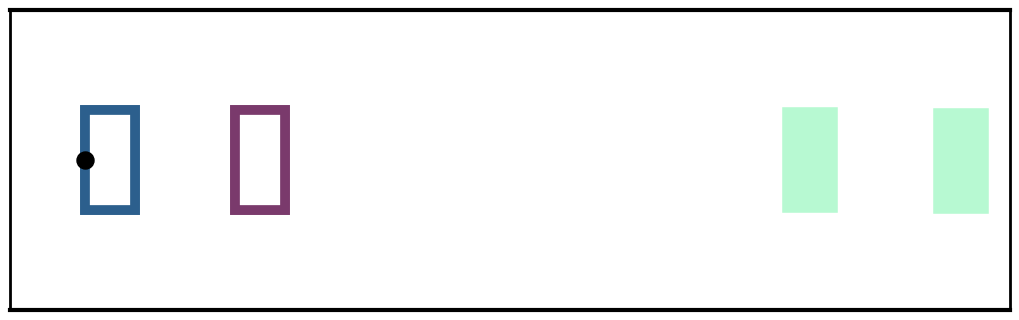

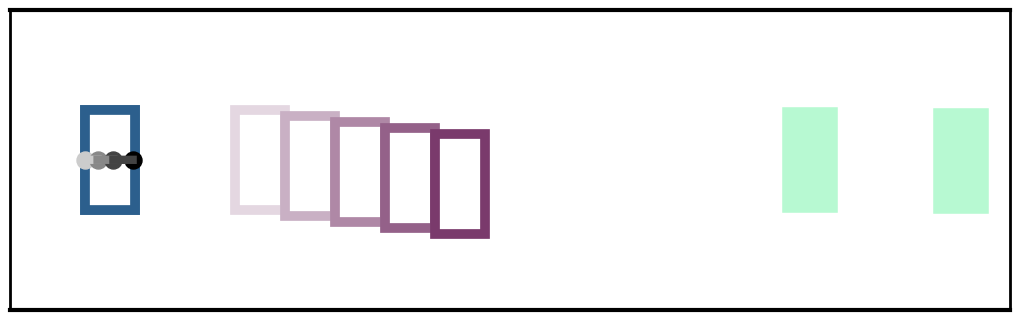

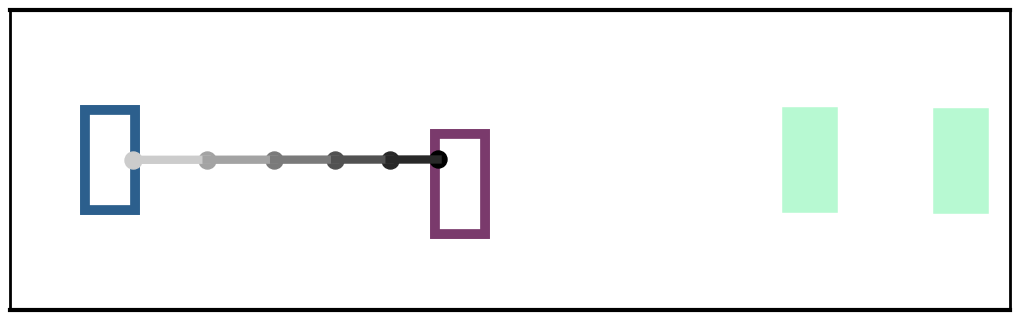

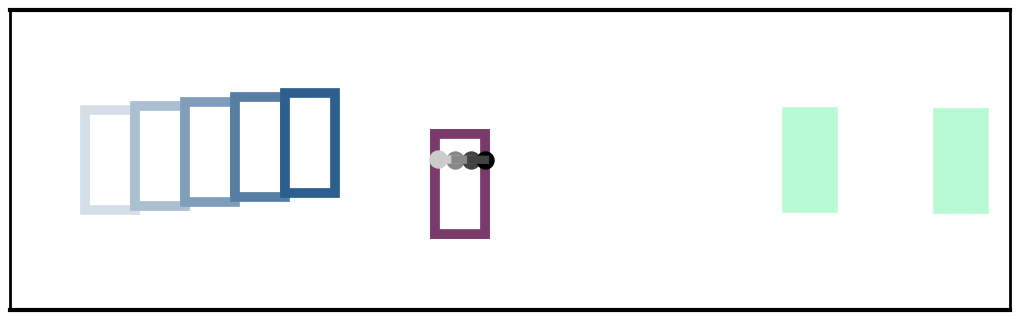

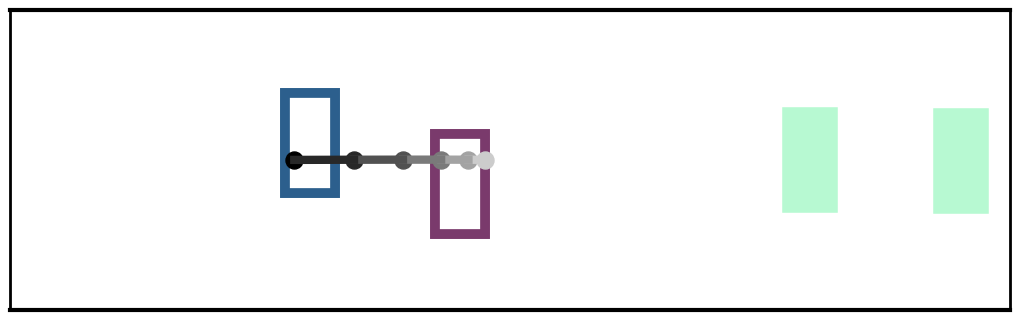

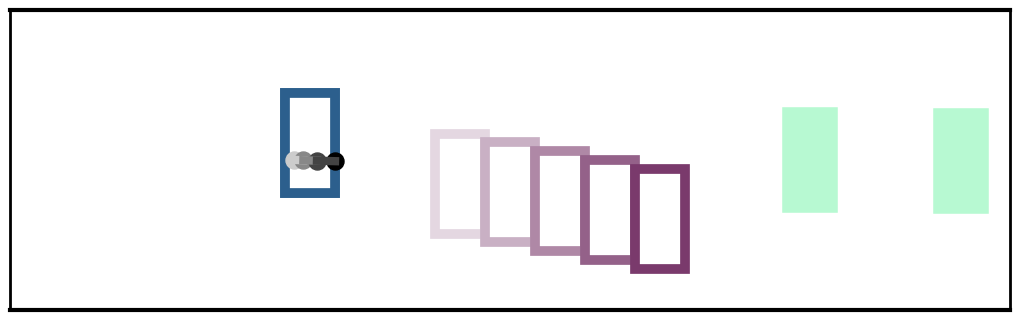

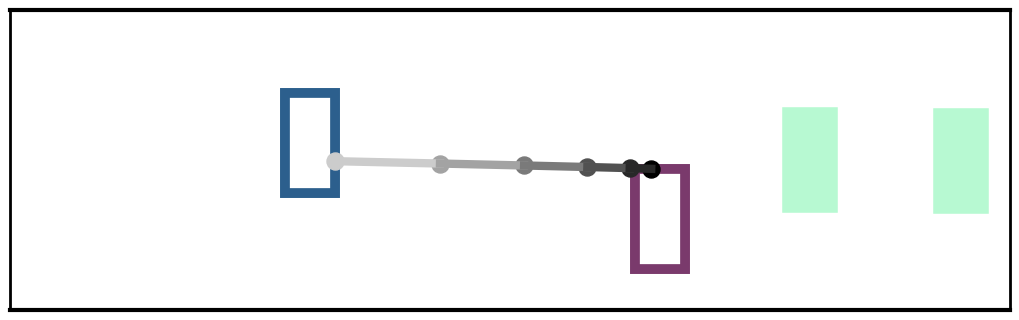

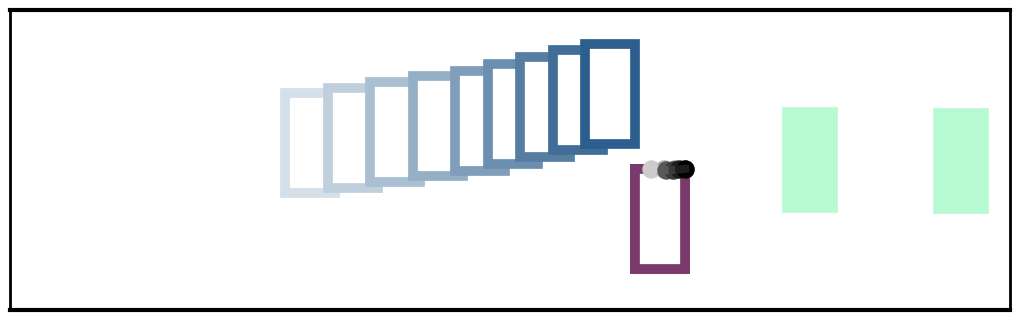

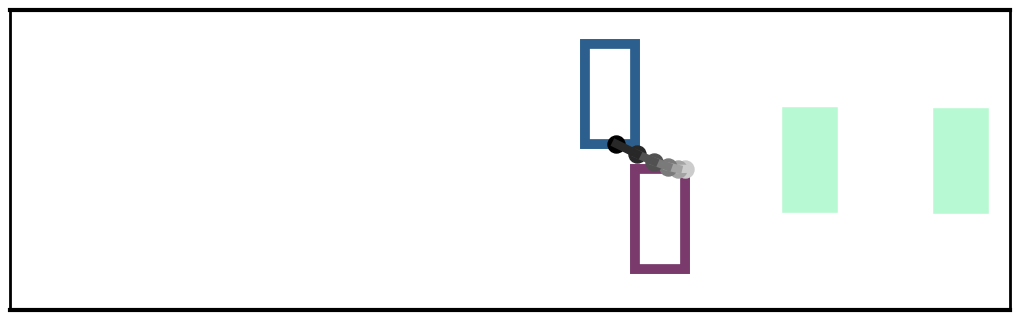

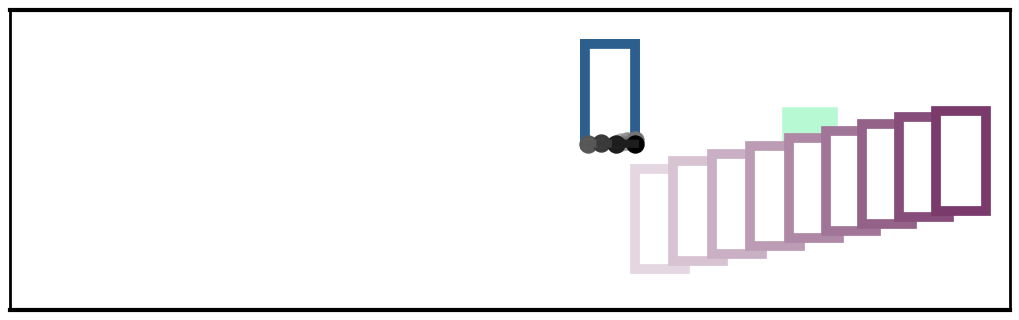

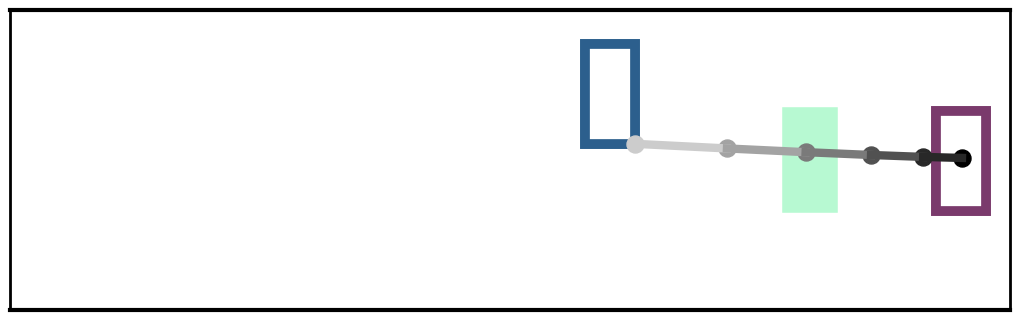

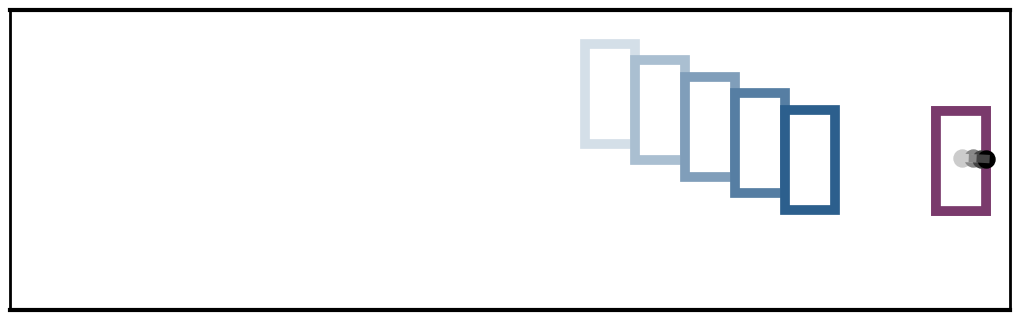

In [30]:
# animate_footstep_plan_images(w,h,dt,restriction,z,g, ylim=[-0.48,0.22], xlim=[-1.75,0.25], num_interpolation_points=5, 
#                              save_fig_title = "lateral_collision",
#                              fig_width = 9,
#                              fig_height = 3,
#                              plot_circle = (-0.7,0.2,0.35)
#                              )

animate_footstep_plan_images(w,h,dt,restriction,z,g, ylim=[-0.3,0.3], xlim=[-1.75,0.25], num_interpolation_points=5, 
                            #  save_fig_title = "lateral_simple",
                             fig_width = 10,
                             fig_height = 3,
                             )

# diagonal stepping

In [ ]:
def get_standing_at_xy(p,v):
    return np.array([p[0], p[1], v[0], v[1], p[0]-0.15, p[1], p[0]+0.15, p[1]])

state = get_standing_at_xy([-1.5, -1.5], [0,0]) # 0.73s on my machine # 160ms on Nick's
restriction, solve_time = obtain_rollout(graph, 2, Ld_Rd_1, state)
if restriction is not None:
    YAY(restriction.vertex_names())
    YAY(solve_time)
else:
    ERROR("failed to solve")
check_that_foot_forces_exist(restriction,z,m,g,w,h,mu)

# animate_footstep_plan(w,h,dt,restriction,z,g, ylim=[-0.5,0.5], xlim=[-2.25,0.25], scale_time=3, num_interpolation_points=10, bbox_to_anchor=(-0.05,-0.1,0,0),)
# animate_footstep_plan(w,h,dt,restriction,z,g, ylim=[-2.25,0.25], xlim=[-0.5,0.5], scale_time=3, num_interpolation_points=10, bbox_to_anchor=(-1.15,-0.1,0,0))
animate_footstep_plan(w,h,dt,restriction,z,g, ylim=[-1.75,0.25], xlim=[-1.75,0.25], scale_time=3, num_interpolation_points=5, bbox_to_anchor=(-0.2,-0.1,0,0),
                      use_proper_cop_location=True)

['Ld_Rd_1' 'Lu_Rd_1' 'Lu_Rd_1' 'Ld_Rd_1' 'Ld_Ru_1' 'Ld_Ru_1' 'Ld_Ru_2'
 'Ld_Rd_2' 'Lu_Rd_2' 'Lu_Rd_2' 'Lu_Rd_1' 'Ld_Rd_1' 'Ld_Ru_1' 'Ld_Rd_1'
 'Lu_Rd_1' 'Ld_Rd_1' 'Ld_Ru_1' 'target']
['Ld_Rd_1' 'Ld_Rd_1' 'Ld_Rd_1' 'Ld_Rd_1' 'Ld_Rd_1' 'Ld_Rd_1' 'Ld_Rd_1'
 'Ld_Rd_1' 'Ld_Rd_1' 'Lu_Rd_1' 'Lu_Rd_1' 'Lu_Rd_1' 'Lu_Rd_1' 'Lu_Rd_1'
 'Lu_Rd_1' 'Lu_Rd_1' 'Lu_Rd_1' 'Lu_Rd_1' 'Lu_Rd_1' 'Lu_Rd_1' 'Lu_Rd_1'
 'Lu_Rd_1' 'Lu_Rd_1' 'Lu_Rd_1' 'Lu_Rd_1' 'Lu_Rd_1' 'Lu_Rd_1' 'Ld_Rd_1'
 'Ld_Rd_1' 'Ld_Rd_1' 'Ld_Rd_1' 'Ld_Rd_1' 'Ld_Rd_1' 'Ld_Rd_1' 'Ld_Rd_1'
 'Ld_Rd_1' 'Ld_Ru_1' 'Ld_Ru_1' 'Ld_Ru_1' 'Ld_Ru_1' 'Ld_Ru_1' 'Ld_Ru_1'
 'Ld_Ru_1' 'Ld_Ru_1' 'Ld_Ru_1' 'Ld_Ru_1' 'Ld_Ru_1' 'Ld_Ru_1' 'Ld_Ru_1'
 'Ld_Ru_1' 'Ld_Ru_1' 'Ld_Ru_1' 'Ld_Ru_1' 'Ld_Ru_1' 'Ld_Ru_2' 'Ld_Ru_2'
 'Ld_Ru_2' 'Ld_Ru_2' 'Ld_Ru_2' 'Ld_Ru_2' 'Ld_Ru_2' 'Ld_Ru_2' 'Ld_Ru_2'
 'Ld_Rd_2' 'Ld_Rd_2' 'Ld_Rd_2' 'Ld_Rd_2' 'Ld_Rd_2' 'Ld_Rd_2' 'Ld_Rd_2'
 'Ld_Rd_2' 'Ld_Rd_2' 'Lu_Rd_2' 'Lu_Rd_2' 'Lu_Rd_2' 'Lu_Rd_2' 'Lu_Rd_2'
 'Lu_Rd_2' 'Lu_Rd_2' 'Lu_Rd_2' 'Lu_R

# forward stepping

In [ ]:
def get_standing_at_xy(p,v):
    return np.array([p[0], p[1], v[0], v[1], p[0]-0.15, p[1], p[0]+0.15, p[1]])

# state = get_standing_at_xy([-2, 0], [0,0]) # 1.3s on my machine, 300ms on Nick's
state = get_standing_at_xy([0, -2], [0,0]) # 0.49s on my machine # 120ms on Nick's
# state = get_standing_at_xy([-1.5, -1.5], [0,0]) # 0.73s on my machine # 160ms on Nick's
restriction, solve_time = obtain_rollout(graph, 2, Ld_Rd_1, state)
if restriction is not None:
    YAY(restriction.vertex_names())
    YAY(solve_time)
else:
    ERROR("failed to solve")
check_that_foot_forces_exist(restriction,z,m,g,w,h,mu)

animate_footstep_plan(w,h,dt,restriction,z,g, ylim=[-2.25,0.25], xlim=[-0.5,0.5], scale_time=3, num_interpolation_points=10, bbox_to_anchor=(-1.15,-0.1,0,0))